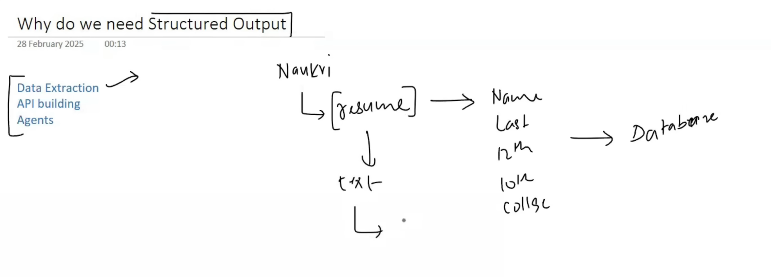

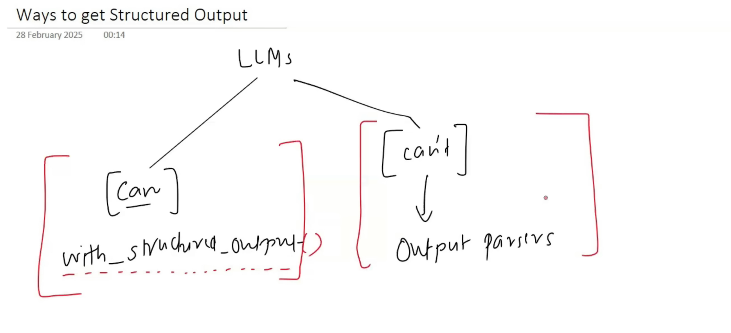

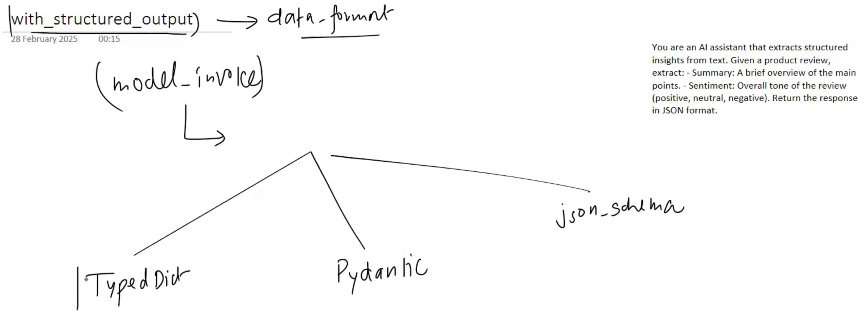

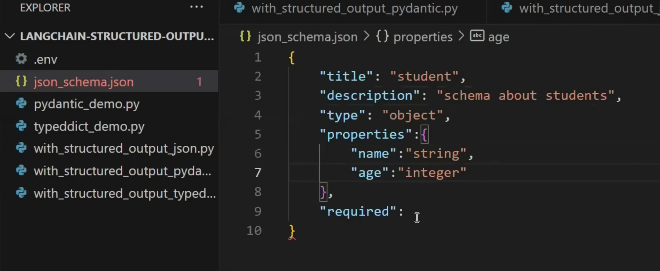

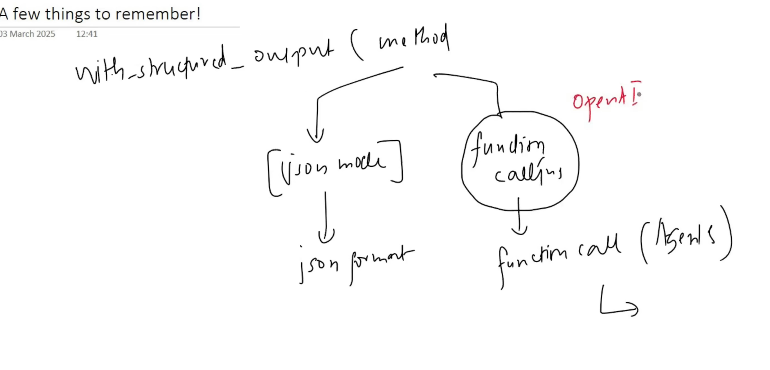


---

## Structured Output in LangChain: A Stepwise Summary

### Step 1: Understanding Structured vs. Unstructured Output

Traditionally, when interacting with an LLM (like ChatGPT), the input (prompt) and the output are generally text. This textual output is considered **unstructured output** because text inherently lacks a defined structure. For example, asking for the capital of India returns a textual response: "New Delhi is the capital of India".

**Structured Output** refers to having Language Models return responses in a **well-defined data format**, such as JSON.

### Step 2: Motivation and Use Cases

The primary goal of structured output is to enable LLMs to communicate with other machines or systems, such as databases or APIs, which is often impossible with unstructured textual data.

Structured Output is a powerful technique with several key use cases:

1.  **Data Extraction:** Extracting key information (like a candidate's name, last company, or marks) from documents (e.g., resumes) and storing it systematically in a database using a structured format (JSON).
2.  **API Building:** Processing long textual reviews to extract key information (topics discussed, pros, cons, overall sentiment) and structuring this information, which can then be served globally via an API (e.g., using Flask or FastAPI).
3.  **Building Agents:** Structured output is vital for building Agents—chatbots that can perform tasks using **Tools**. Tools, such as a calculator, cannot process plain text inputs (like "Find the square root of two"); they require structured data (e.g., knowing the operation is "square root" and the input number is "2").

### Step 3: Generating Structured Output in LangChain

Generating structured output in LangChain depends on the type of LLM being used.

1.  **For LLMs that inherently support structured output** (e.g., OpenAI's GPT models), LangChain provides the simplified function: `with_structured_output`.
2.  **For LLMs that do not support structured output** (e.g., certain open-source models like TinyLlama), you must use **Output Parsers** (not covered in detail here, but required to impose structure on unstructured results).

When using the `with_structured_output` function, it generates a system prompt containing the required output structure, which is sent along with the user prompt to the LLM. The LLM then returns the response in the specified structured format (often JSON, which appears as a Python dictionary).

### Step 4: Schema Definition Methods

The `with_structured_output` function requires a defined data format (schema). There are three primary methods to define this schema:

#### 4a. Using Typed Dictionary

Typed Dictionary is a Python mechanism used to define the expected keys and data types within a dictionary, helping to ensure the dictionary follows a specific structure.

*   **Mechanism:** Define a class inheriting from `TypedDict` and specify the key names and their data types.
*   **Limitation:** It provides **type hinting** but offers **no guarantee** of data integrity. If the LLM returns data in the wrong format, Typed Dictionary will **not** validate it or raise an error.
*   **Enhancements:** Can use `Annotated` to provide descriptions for the LLM to understand the required output (e.g., "A brief summary of the review"). Can use `Optional` for fields that might be missing.

**Code Example (Basic Schema Definition):**
```python
from typing import TypedDict, Optional, Annotated

class Review(TypedDict):
    # Field Definition using Type Hinting and Annotation
    summary: Annotated[str, "A brief overview of the main points"]
    
    # Optional Field Definition
    sentiment: Optional[str]
```
**LangChain Integration:**
```python
# Assuming 'model' is the LLM instance
structured_model = model.with_structured_output(Review)
# Invoke the structured model
result = structured_model.invoke(review_text)
# Output is a Python Dictionary
print(result['summary'])
```

#### 4b. Using Pydantic (Recommended for Python Projects)

Pydantic is a specialized Python library focused on **data validation and parsing**.

*   **Mechanism:** Define a class inheriting from `BaseModel` (imported from `pydantic`).
*   **Key Advantage: Data Validation:** Pydantic is superior because it performs **data validation** and raises an error if the input does not meet the criteria (e.g., passing an integer when a string is required).
*   **Features:**
    *   **Type Coercion:** Smartly attempts to convert data to the expected type (e.g., converting a string `"32"` to the integer `32`).
    *   **Constraints:** Allows setting constraints (e.g., a CGPA must be greater than 0 and less than 10) using the `Field` function.
    *   **Description:** The `Field` function also allows adding descriptions for LLM guidance.
*   **Output:** The result is a Pydantic object, which can be accessed via dot notation (e.g., `result.summary`) or converted to a Python dictionary (`.dict()`) or JSON (`.json()`).

**Code Example (Schema fragment using Pydantic):**
```python
from pydantic import BaseModel, Field
from typing import List, Optional, Literal

# Define accepted sentiments
SentimentLiteral = Literal["Positive", "Negative"]

class Review(BaseModel):
    # Key themes as a list of strings with description
    key_themes: List[str] = Field(description="List of all key themes discussed.")
    
    # Sentiment restricted to specific literals (Positive or Negative)
    sentiment: SentimentLiteral = Field(description="Overall tone of the review.")
    
    # Optional field that defaults to None if not present
    name: Optional[str] = Field(default=None)
```
**LangChain Integration:**
```python
# Assuming 'model' is the LLM instance
structured_model = model.with_structured_output(Review)
# Invoke the structured model
result = structured_model.invoke(review_text)
# Output is a Pydantic object
print(result.key_themes)
```

#### 4c. Using JSON Schema

JSON Schema is used when the project requires the schema definition to be shared across **multiple programming languages** (e.g., Python backend and JavaScript frontend), as JSON is a universal data format.

*   **Mechanism:** The schema is defined explicitly using JSON syntax, specifying the `title`, `description`, `type` (e.g., `"object"`), `properties` (attributes), and which fields are `required`.
*   **Syntax Difference:** Uses `"array"` for lists and `enum` for restricted value options (where Pydantic uses `Literal`).
*   **Output:** The LLM output, when provided the JSON schema, is a standard Python dictionary.

**Code Example (Schema Structure Fragment):**
```python
json_schema = {
  "title": "Review",
  "type": "object",
  "properties": {
    "key_themes": {
      "type": "array",
      "items": {"type": "string"},
      "description": "..."
    },
    "sentiment": {
      "type": "string",
      "enum": ["Positive", "Negative", "Neutral"]
    }
  },
  "required": ["key_themes", "sentiment"]
}
```
**LangChain Integration:**
```python
# Assuming 'model' is the LLM instance
structured_model = model.with_structured_output(json_schema)
# The schema variable itself is passed
result = structured_model.invoke(review_text)
# Output is a Python Dictionary
print(result['sentiment'])
```

### Step 5: Comparison of Schema Definition Methods

| Feature | Typed Dictionary | Pydantic (Recommended for Python) | JSON Schema |
| :--- | :--- | :--- | :--- |
| **Data Validation** | Only provides type hints. | **Full Data Validation** and error raising. | No explicit validation. |
| **Default Values** | Not supported for validation. | **Supported** via `default` or `Field(default=...)`. | Not supported. |
| **Type Conversion** | No. | **Yes** (Type Coercion). | No. |
| **Cross-Language Use** | No (Python only). | No (Python only). | **Yes** (Universal data format). |

**Conclusion:** Pydantic is the recommended "go-to format" for defining schemas in LangChain within the Python ecosystem due to its powerful validation and constraint capabilities.

### Step 6: Advanced Configuration (`method` Parameter)

When calling `with_structured_output`, you can specify the `method` parameter to instruct the model how to generate the structured output:

1.  **`json_mode`**: Used when the desired output is simply JSON format. This mode is suitable for models like Claude or Gemini which natively support structured output via JSON.
2.  **`function_calling`**: Used specifically when the structured output is intended to invoke another function or tool, typically when building Agents. This is the recommended default for OpenAI models.





---

## Step 1: Comparison of Unstructured Output vs. Structured Output

Traditionally, interactions with Language Models (LLMs) involve sending a text prompt (input) and receiving a text response (output). This standard text output is called **unstructured output**.

**Structured Output** is the practice of having Language Models return responses in a **well-defined data format**, such as JSON.

| Feature | Unstructured Output | Structured Output |
| :--- | :--- | :--- |
| **Format** | Text (e.g., "New Delhi is the capital of India"). | Well-defined data format (e.g., JSON, appearing as a Python dictionary). |
| **Communication** | Primarily human-to-LLM interaction. | Enables LLM-to-machine/system communication (e.g., databases, APIs). |
| **Programmatic Use** | Output is difficult to parse and integrate programmatically. | Output is easier to parse and work with programmatically. |
| **Use Cases** | General Q&A, content generation. | **Data Extraction**, **API Building**, **Building Agents/Tools** (which require structured data inputs). |

The primary function of structured output is to give the LLM output a structure or data format, allowing the LLM to integrate with other systems.

## Step 2: Enabling Structured Output in LangChain

For LLMs that inherently support generating structured output (like OpenAI's GPT models), LangChain simplifies the process using the `with_structured_output` function.

When this function is called, it generates a **system prompt** that defines the required output structure (the schema). This system prompt is sent along with the user prompt to the LLM. The LLM, trained to return JSON output, provides the structured result.

**Basic Flow:**
1. Define the desired structure (Schema, e.g., using Pydantic, TypedDict, or JSON Schema).
2. Call `model.with_structured_output(Schema)` to create a structured model chain.
3. Invoke the structured model with the input text (review, document, etc.).

---

## Step 3: Comparison of Schema Definition Methods

LangChain supports three primary methods for defining the required data format (schema) when using `with_structured_output`:

| Feature | Typed Dictionary | Pydantic (Recommended for Python) | JSON Schema |
| :--- | :--- | :--- | :--- |
| **Core Function** | Defines dictionary structure; provides type hints. | **Data Validation** and parsing. | Universal data format standard. |
| **Validation/Checks** | **None** (Only type representation). | **Full Data Validation** (raises errors if constraints are violated). | No explicit validation when used alone in Python flow. |
| **Language Support** | Python only. | Python only. | **Cross-Language Compatible** (Universal format). |
| **Key Features** | `Annotated` for descriptions, `Optional` for missing fields. | Type Coercion, Constraints (using `Field`), Default values. | Uses `"array"` (for lists) and `"enum"` (for restricted options). |
| **Output Type** | Python `dict`. | Pydantic object (access via dot notation). | Python `dict`. |
| **When to Use** | When you only need type hints and are certain the LLM will provide correct types. | **Go-to format** for Python projects where data integrity and validation are crucial. | When the schema must be shared across multiple languages (e.g., Python backend, JavaScript frontend). |

---

## Step 4: Schema Definition using Typed Dictionary

**Typed Dictionary** is a Python mechanism used to define the expected keys and data types within a dictionary, ensuring it follows a specific structure.

**Code Usage (Definition and Integration):**

1.  **Imports:** Import `TypedDict` from `typing`. Optionally import `Annotated` for adding descriptions and `Optional` for setting optional fields.
2.  **Schema Definition:** Define a class inheriting from `TypedDict`.

```python
from typing import TypedDict, Annotated, Optional
# Assuming we want to extract Summary and Sentiment, and optionally the Reviewer's Name

class Review(TypedDict):
    # Field with Description (Annotation)
    summary: Annotated[str, "A brief summary of the main points"]
    
    # Field that restricts values (Literal can also be used, as shown in source)
    sentiment: str
    
    # Optional field
    reviewer_name: Optional[str]
```

3.  **LangChain Integration and Output Access:**

```python
# Assuming 'model' is the LLM instance
structured_model = model.with_structured_output(Review)

# Invoke the structured model
result = structured_model.invoke(review_text)

# Output is a Python Dictionary, accessed via bracket notation
print(result['summary'])
print(result['sentiment'])
```

**Note:** Typed Dictionary provides **no guarantee** of data integrity; it only provides representation.

## Step 5: Schema Definition using Pydantic

**Pydantic** is recommended in the Python ecosystem because it provides robust **data validation** and supports features like constraints and type coercion.

**Code Usage (Definition and Integration):**

1.  **Imports:** Import `BaseModel` and `Field` from `pydantic`.

2.  **Schema Definition:** Define a class inheriting from `BaseModel`. Use `Field` to add descriptions or constraints (like `gt=0` or `lt=10` for a CGPA).

```python
from pydantic import BaseModel, Field
from typing import List, Optional, Literal

# Define accepted sentiments using Literal
SentimentLiteral = Literal["Positive", "Negative"]

class Review(BaseModel):
    # List of strings with required description using Field
    key_themes: List[str] = Field(
        description="List of all key themes discussed in the review."
    )
    
    # Sentiment restricted to specific literals
    sentiment: SentimentLiteral = Field(
        description="Overall tone of the review (Positive or Negative)."
    )
    
    # Optional field with default value set to None
    reviewer_name: Optional[str] = Field(default=None)
```

3.  **LangChain Integration and Output Access:**

```python
# Assuming 'model' is the LLM instance
structured_model = model.with_structured_output(Review)

# Invoke the structured model
result = structured_model.invoke(review_text)

# Output is a Pydantic object, accessed via dot notation (OOP style)
print(result.key_themes)
print(result.sentiment)
```

## Step 6: Schema Definition using JSON Schema

**JSON Schema** is the preferred method when the schema must be easily understood and shared across different programming languages.

**Code Usage (Definition and Integration):**

1.  **Schema Definition:** The schema is defined as a Python dictionary following the JSON Schema specification, which specifies `title`, `type` (`"object"`), `properties`, and `required` fields. Note the use of `"array"` and `"enum"`.

```python
json_schema = {
    "title": "Review",
    "type": "object", # Corresponds to a Python dictionary
    "description": "Schema about smartphone reviews.",
    "properties": {
        "key_themes": {
            "type": "array", # Corresponds to a Python list
            "items": {"type": "string"},
            "description": "List of all key themes discussed in the review."
        },
        "sentiment": {
            "type": "string",
            "enum": ["Positive", "Negative", "Neutral"], # Restricts possible values
            "description": "Overall tone of the review."
        }
    },
    "required": ["key_themes", "sentiment"]
}
```

2.  **LangChain Integration and Output Access:**

```python
# Assuming 'model' is the LLM instance
# Pass the schema dictionary directly
structured_model = model.with_structured_output(json_schema)

# Invoke the structured model
result = structured_model.invoke(review_text)

# Output is a Python Dictionary, accessed via bracket notation
print(result['key_themes'])
print(result['sentiment'])
```